In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


**GENERATING DATA**

In [ ]:
def manufactured_solution(X, Y, T, nu):
    alpha = 2.0 + 5.0*nu
    beta  = 1.0 + 3.0*nu
    u = np.sin(np.pi*X) * np.sin(np.pi*Y) * np.exp(-alpha*T)
    v = np.cos(np.pi*X) * np.cos(np.pi*Y) * np.exp(-beta*T)
    return u, v

def build_dataset(nus, nx=32, ny=32, nt=20, Tfinal=0.5, noise_level=0.0):
    xs = np.linspace(0,1,nx)
    ys = np.linspace(0,1,ny)
    ts = np.linspace(0,Tfinal,nt)
    X_list, Y_list = [], []
    for nu in nus:
        for t in ts:
            Xg, Yg = np.meshgrid(xs, ys, indexing='ij')
            u, v = manufactured_solution(Xg, Yg, t, nu)
            N = Xg.size
            inp = np.stack([Xg.reshape(N), Yg.reshape(N), np.full(N,t), np.full(N,nu)], axis=-1)
            out = np.stack([u.reshape(N), v.reshape(N)], axis=-1)
            # Add noise to the output data
            if noise_level > 0:
                out += np.random.normal(0, noise_level, out.shape)
            X_list.append(inp)
            Y_list.append(out)
    X = np.vstack(X_list).astype(np.float32)
    Y = np.vstack(Y_list).astype(np.float32)
    return X, Y

In [ ]:
train_nus = np.array([0.01, 0.05, 0.2])
test_nus  = np.array([0.02, 0.1])

X_train, Y_train = build_dataset(train_nus, nx=16, ny=16, nt=10)
X_test,  Y_test  = build_dataset(test_nus, nx=16, ny=16, nt=10)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (7680, 4) (5120, 4)


**NORMALIZE INPUT DATA**

In [ ]:
x_mean = X_train.mean(axis=0)
x_std = X_train.std(axis=0) + 1e-8
def normalize(x): return (x - x_mean)/x_std

Xtr = torch.tensor(normalize(X_train), dtype=torch.float32, device=device)
Ytr = torch.tensor(Y_train, dtype=torch.float32, device=device)
Xte = torch.tensor(normalize(X_test), dtype=torch.float32, device=device)
Yte = torch.tensor(Y_test, dtype=torch.float32, device=device)

In [ ]:
def make_collocation(n_coll=6000):
    xs = np.random.rand(n_coll)
    ys = np.random.rand(n_coll)
    ts = np.random.rand(n_coll)*0.5
    nus_sample = np.random.choice(train_nus, size=n_coll)
    pts = np.stack([xs, ys, ts, nus_sample], axis=-1).astype(np.float32)
    return torch.tensor(normalize(pts), device=device, dtype=torch.float32)
Xcoll = make_collocation(6000)

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers=[4,128,128,128,2]):
        super().__init__()
        mods=[]
        for i in range(len(layers)-1):
            mods.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2: mods.append(nn.Tanh())
        self.net = nn.Sequential(*mods)
    def forward(self,x): return self.net(x)

model = PINN().to(device)
print(model)

PINN(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
mean_nu = x_mean[3]
std_nu  = x_std[3]
std = torch.tensor(x_std, device=device, dtype=torch.float32)

def physics_residuals(model, x_coll):
    x_coll = x_coll.clone().detach().requires_grad_(True)
    out = model(x_coll)
    u = out[:,0:1]; v = out[:,1:2]

    du = torch.autograd.grad(u, x_coll, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    dv = torch.autograd.grad(v, x_coll, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    du_dx = du[:,0:1]/std[0]; du_dy = du[:,1:2]/std[1]; du_dt = du[:,2:3]/std[2]
    dv_dx = dv[:,0:1]/std[0]; dv_dy = dv[:,1:2]/std[1]; dv_dt = dv[:,2:3]/std[2]

    d2u_dx2 = torch.autograd.grad(du[:,0:1], x_coll, torch.ones_like(u), create_graph=True)[0][:,0:1]/std[0]
    d2u_dy2 = torch.autograd.grad(du[:,1:2], x_coll, torch.ones_like(u), create_graph=True)[0][:,1:2]/std[1]
    d2v_dx2 = torch.autograd.grad(dv[:,0:1], x_coll, torch.ones_like(v), create_graph=True)[0][:,0:1]/std[0]
    d2v_dy2 = torch.autograd.grad(dv[:,1:2], x_coll, torch.ones_like(v), create_graph=True)[0][:,1:2]/std[1]

    nu_phys = x_coll[:,3:4]*std_nu + mean_nu
    res_u = du_dt + u*du_dx + v*du_dy - nu_phys*(d2u_dx2 + d2u_dy2)
    res_v = dv_dt + u*dv_dx + v*dv_dy - nu_phys*(d2v_dx2 + d2v_dy2)
    return res_u, res_v


Epoch    1/600  data=4.516e-02  phys=5.214e-01  test_mse=2.371e-02
Epoch  100/600  data=9.669e-03  phys=1.295e-03  test_mse=1.033e-02
Epoch  200/600  data=9.694e-03  phys=1.102e-03  test_mse=1.015e-02
Epoch  300/600  data=9.800e-03  phys=2.106e-03  test_mse=1.014e-02
Epoch  400/600  data=9.708e-03  phys=8.966e-04  test_mse=1.004e-02
Epoch  500/600  data=9.725e-03  phys=1.003e-03  test_mse=9.916e-03
Epoch  600/600  data=9.301e-03  phys=7.345e-04  test_mse=1.000e-02


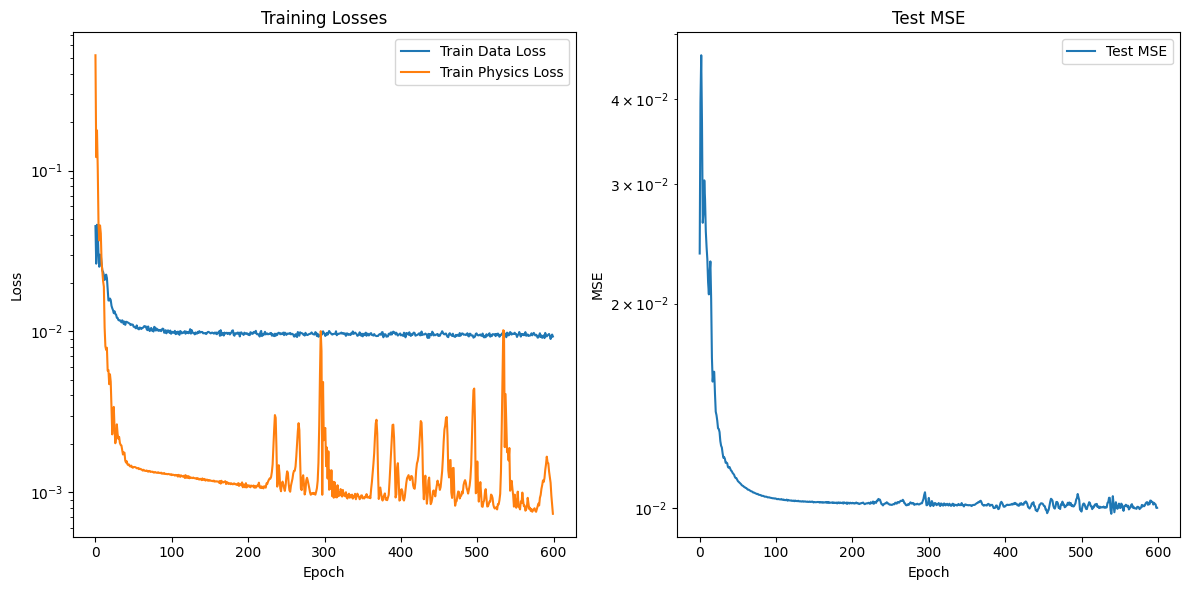

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
batch = 4096
n_epochs = 600

# Lists to store loss values for plotting
train_data_losses = []
train_phys_losses = []
test_mses = []

for epoch in range(1, n_epochs+1):
    perm = torch.randperm(Xtr.shape[0])
    Xsh = Xtr[perm]; Ysh = Ytr[perm]
    model.train() # Set model to training mode
    for i in range(0, Xtr.shape[0], batch):
        xb = Xsh[i:i+batch]; yb = Ysh[i:i+batch]
        opt.zero_grad()
        pred = model(xb)
        data_loss = torch.mean((pred - yb)**2)
        res_u, res_v = physics_residuals(model, Xcoll)
        phys_loss = torch.mean(res_u**2) + torch.mean(res_v**2)
        loss = data_loss + 1.0*phys_loss
        loss.backward()
        opt.step()

    # Evaluate on test set and record losses
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        pred_test = model(Xte)
        test_mse = torch.mean((pred_test - Yte)**2).item()

    # Append losses to lists
    train_data_losses.append(data_loss.item())
    train_phys_losses.append(phys_loss.item())
    test_mses.append(test_mse)


    if epoch % 100 == 0 or epoch==1:
        print(f"Epoch {epoch:4d}/{n_epochs}  data={data_loss.item():.3e}  phys={phys_loss.item():.3e}  test_mse={test_mse:.3e}")

# Plotting the loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_data_losses, label='Train Data Loss')
plt.plot(train_phys_losses, label='Train Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.title('Test MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    pred_test = model(Xte).cpu().numpy()

mse = np.mean((pred_test - Y_test)**2)
print("Test MSE:", mse)


Test MSE: 0.009755475


Test MSE: 0.01000073


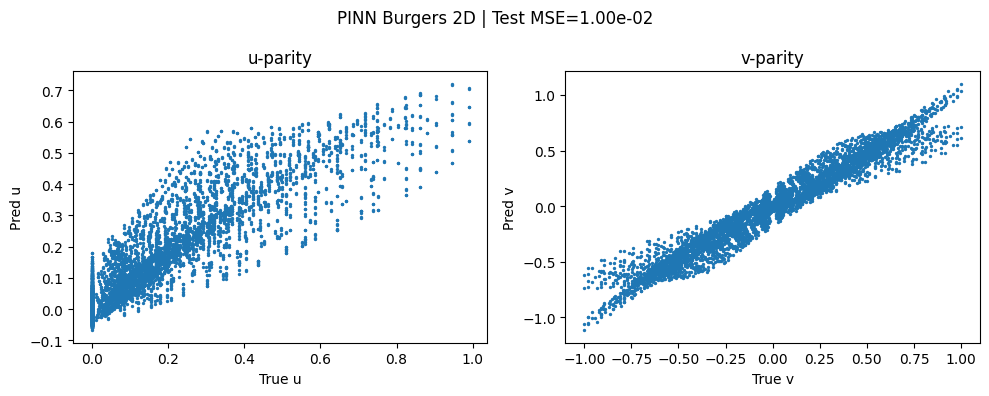

In [ ]:
model.eval()
with torch.no_grad():
    pred_test = model(Xte).cpu().numpy()

mse = np.mean((pred_test - Y_test)**2)
print("Test MSE:", mse)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(Y_test[:,0], pred_test[:,0], s=2)
plt.xlabel('True u'); plt.ylabel('Pred u'); plt.title('u-parity')
plt.subplot(1,2,2)
plt.scatter(Y_test[:,1], pred_test[:,1], s=2)
plt.xlabel('True v'); plt.ylabel('Pred v'); plt.title('v-parity')
plt.suptitle(f"PINN Burgers 2D | Test MSE={mse:.2e}")
plt.tight_layout()
plt.show()